Run inference on the validation set of pt_en dataset, and find `bleu` and `gleu` scores. 

In [1]:
import os
import json
import yaml

In [2]:
import numpy as np
import tensorflow as tf

In [3]:
import matplotlib.pyplot as plt

In [4]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.gleu_score import sentence_gleu

In [5]:
# small model
# with open(os.path.join('configs/config.yml'), 'r') as fym:
#     cfg = yaml.load(fym)
    
# large model
with open(os.path.join('configs/config_large.yml'), 'r') as fym:
    cfg = yaml.load(fym)


In [6]:
cfg

{'model_params': {'num_layers': 6,
  'd_model': 256,
  'dff': 1024,
  'num_heads': 8,
  'dropout_rate': 0.1,
  'max_posit_encode_input': 1000,
  'max_posit_encode_target': 1000},
 'dataset_params': {'batch_size': 64,
  'translate_tokenizers_model': 'ted_hrlr_translate_pt_en_converter',
  'tf_dataset_name': 'ted_hrlr_translate/pt_to_en'},
 'train_params': {'epochs': 200,
  'steps_per_epoch': 800,
  'validation_steps': 20},
 'metric_params': None}

### Build and load the model

In [7]:
from train import build_model, training_datasets

In [8]:
cache_dir = '/home/payam/Documents/translate_data'

In [9]:
data = training_datasets(cfg, cache_dir)

In [10]:
m = build_model(cfg, data)

Runs a mock step to load saved weights. Ideally, checkpoints should have been saved using `save_weights`. 

In [11]:
m.call(inputs={'input': tf.zeros((1, 10)), 'target': tf.zeros((1, 10))}, training=False)
m.built = True

In [12]:
# weights = '/home/payam/Documents/checkpoints/transformer_pt_en/weights.30.hdf5'  # small epoch 30
# weights = '/home/payam/Documents/checkpoints/transformer_pt_en/weights.15.hdf5'  # small epoch 15
weights = '/home/payam/Documents/checkpoints/transformer_pt_en_large/weights.12.hdf5'  # large epoch 12

m.load_weights(weights)

#### Loss function for the small and large models, basis for picking specific epochs. 
#### Small
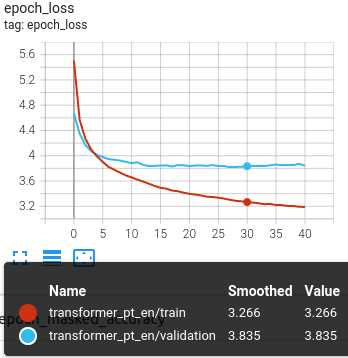


#### Large
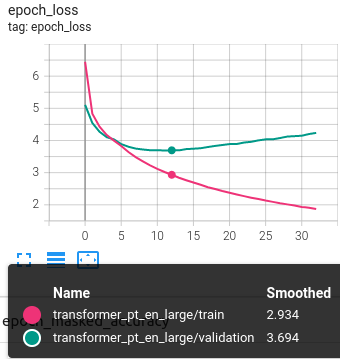

### Load validation data

In [13]:
import tensorflow_datasets as tfds

In [14]:
d, _ = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)

In [15]:
dval = d['validation']

In [16]:
len(dval)

1193

### Build translator

In [17]:
from datasets import pt_to_en_tokenizers, translation_train_and_val_from_tfds

In [18]:
from run_inference import Translator

In [19]:
input_tokenizer, target_tokenizer = pt_to_en_tokenizers(cache_dir)

In [20]:
t = Translator(input_tokenizer, target_tokenizer, transformer=m)

### Calculate metrics for the val set

In [21]:
bleu_max_order = 4
metrics = {f'bleu_{i}': [] for i in range(1, bleu_max_order + 1)}
metrics['gleu'] = []
preds = []

for i, (x, y) in enumerate(dval):
    if i % 20 == 0:
        print(f'processed {i} for far')
    x_str = x.numpy().decode('utf-8')
    out_text, _ = t(x, 5 * len(x_str.split()))
    
    yt_str = y.numpy().decode('utf-8')
    yt = yt_str.split()  # List[str]
    
    yp_str = out_text.numpy().decode('utf-8')
    yp = yp_str.split()  # List[str]
    
    gleu = sentence_gleu(yt, yp)
    metrics['gleu'].append(gleu)
    for i in range(1, bleu_max_order + 1):
        metrics[f'bleu_{i}'].append(sentence_bleu(yt, yp, weights=np.ones(i) / i))
    
    preds.append(yp_str)
    if gleu > 0.1:
        print(f'input: {x_str}\nlabel: {yt_str}\nprediction: {yp_str}\ngleu score: {gleu}\n')

processed 0 for far


/home/payam/.venvs/tensorflow/lib/python3.6/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/payam/.venvs/tensorflow/lib/python3.6/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/payam/.venvs/tensorflow/lib/python3.6/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-g

processed 20 for far
input: não era que eu não tentasse .
label: it 's not because he did n't try .
prediction: i did n ' t have to try to try .
gleu score: 0.15789473684210525

input: ( aplausos )
label: ( applause )
prediction: ( applause )
gleu score: 0.16666666666666666

input: sem piada nenhuma .
label: and without the humor .
prediction: no .
gleu score: 0.3333333333333333

processed 40 for far
input: é uma coleção de rostos .
label: it 's a collection of faces .
prediction: it ' s a set of instructions .
gleu score: 0.11538461538461539

processed 60 for far
input: ( aplausos )
label: ( applause )
prediction: ( applause )
gleu score: 0.16666666666666666

processed 80 for far
processed 100 for far
processed 120 for far
processed 140 for far
processed 160 for far
processed 180 for far
processed 200 for far
input: não quero dizer grande , uma enorme esperança .
label: i do n't mean big , grand hope .
prediction: i do n ' t think of a big problem .
gleu score: 0.15789473684210525

in

processed 1040 for far
input: ( risos ) não fui eu que o pus lá dentro .
label: ( laughter ) i did n't put him in .
prediction: ( laughter ) i did n ' t have to see that .
gleu score: 0.13043478260869565

processed 1060 for far
input: ( aplausos )
label: ( applause )
prediction: ( applause )
gleu score: 0.16666666666666666

input: aqui está o relógio do chris .
label: here 's chris 's clock .
prediction: so here ' s the clip .
gleu score: 0.13636363636363635

processed 1080 for far
processed 1100 for far
input: aqui está outra bem má .
label: here 's another really bad one .
prediction: here ' s another woman .
gleu score: 0.16666666666666666

input: ( aplausos )
label: ( applause )
prediction: ( applause )
gleu score: 0.16666666666666666

processed 1120 for far
input: muito bem .
label: all right .
prediction: very much .
gleu score: 0.16666666666666666

processed 1140 for far
processed 1160 for far
processed 1180 for far


In [22]:
output_dir = '/home/payam/Documents/inference_results/pt_en_transformer'
os.makedirs(output_dir, exist_ok=True)

In [23]:
with open(os.path.join(output_dir, 'metrics_and_preds_large_epoch_12.json'), 'w') as fj:
    all_outs = {**metrics, **{'predictions': preds}}
    json.dump(all_outs, fj)

## Visualize

In [24]:
import pandas as pd

In [25]:
import seaborn as sns

### Small model, using weights from epoch=30

In [69]:
with open(os.path.join(output_dir, 'metrics_and_preds_epoch_30.json'), 'r') as fj:
    metrics = json.load(fj)
metrics = {k: v for k, v in metrics.items() if 'pred' not in k}

In [70]:
df_metrics = pd.DataFrame(metrics)

In [71]:
df_metrics.head()

,bleu_1,bleu_2,bleu_3,bleu_4,gleu
0,0.083333,4.306075e-155,3.455433e-206,9.788429e-232,0.023810
1,0.250000,7.458341e-155,4.983597e-206,1.288230e-231,0.023810
2,0.250000,7.458341e-155,4.983597e-206,1.288230e-231,0.023810
3,0.363636,8.995097e-155,5.646579e-206,1.414735e-231,0.052632
4,0.083333,4.306075e-155,3.455433e-206,9.788429e-232,0.023810


In [72]:
epoch = 30

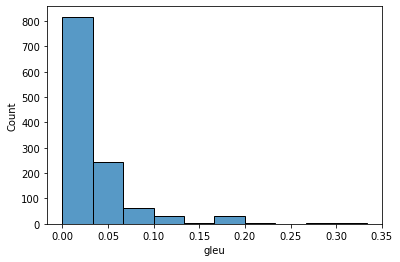

In [73]:
sns.histplot(data=df_metrics, x='gleu', bins=10)
# plt.show()
plt.savefig(os.path.join(output_dir, f'gleu_epoch_epoch_{epoch}.jpg'))

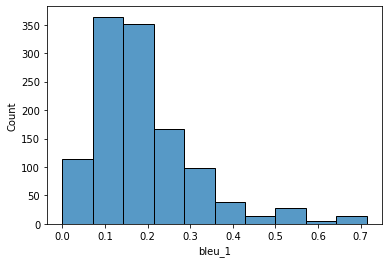

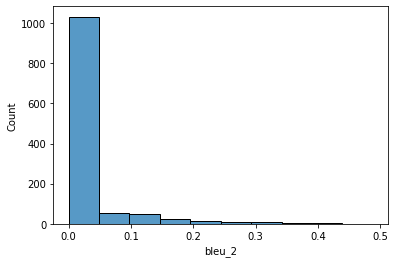

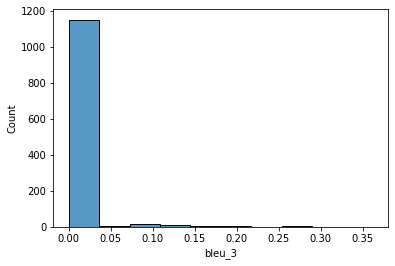

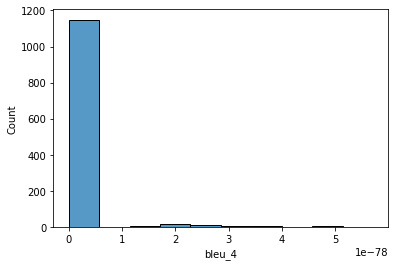

In [74]:
for i in range(1, bleu_max_order + 1):
    sns.histplot(data=df_metrics, x=f'bleu_{i}', bins=10)
    plt.show()
#     plt.savefig(os.path.join(output_dir, f'bleu_{i}_epoch_epoch_{epoch}.jpg'))

### Small model, using weights from epoch=15

In [75]:
with open(os.path.join(output_dir, 'metrics_and_preds_epoch_15.json'), 'r') as fj:
    metrics = json.load(fj)
metrics = {k: v for k, v in metrics.items() if 'pred' not in k}

In [76]:
df_15 = pd.DataFrame(metrics)

In [77]:
df_15.head()

,bleu_1,bleu_2,bleu_3,bleu_4,gleu
0,0.285714,7.973302e-155,5.210430e-206,1.331960e-231,0.045455
1,0.200000,6.670943e-155,4.626362e-206,1.218332e-231,0.027027
2,0.230769,7.165742e-155,4.852389e-206,1.262708e-231,0.021739
3,0.363636,8.995097e-155,5.646579e-206,1.414735e-231,0.052632
4,0.100000,4.717069e-155,3.671946e-206,1.024491e-231,0.029412


In [78]:
epoch = 15

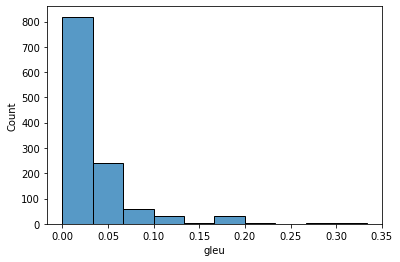

In [79]:
sns.histplot(data=df_15, x='gleu', bins=10)
# plt.show()
plt.savefig(os.path.join(output_dir, f'gleu_epoch_epoch_{epoch}.jpg'))

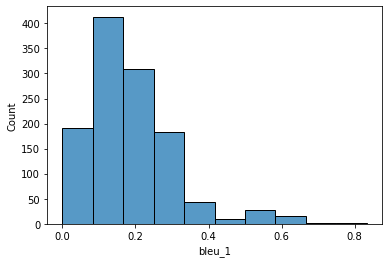

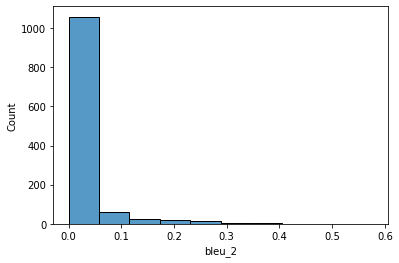

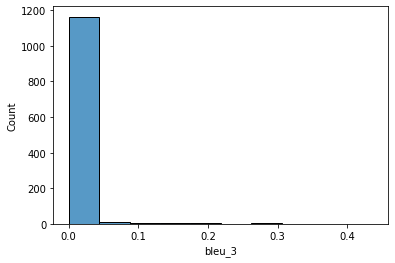

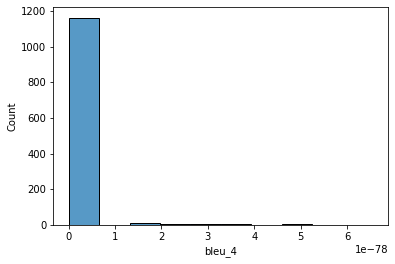

In [80]:
for i in range(1, bleu_max_order + 1):
    sns.histplot(data=df_15, x=f'bleu_{i}', bins=10)
    plt.show()
#     plt.savefig(os.path.join(output_dir, f'bleu_{i}_epoch_epoch_{epoch}.jpg'))

### Large model, using weights from epoch=12

In [26]:
with open(os.path.join(output_dir, 'metrics_and_preds_large_epoch_12.json'), 'r') as fj:
    metrics = json.load(fj)
metrics = {k: v for k, v in metrics.items() if 'pred' not in k}

In [27]:
df_metrics = pd.DataFrame(metrics)

In [28]:
df_metrics.head()

,bleu_1,bleu_2,bleu_3,bleu_4,gleu
0,0.142857,5.637976e-155,4.135521e-206,1.120041e-231,0.045455
1,0.133333,5.446802e-155,4.041500e-206,1.100888e-231,0.018519
2,0.272727,7.789983e-155,5.130257e-206,1.316559e-231,0.026316
3,0.272727,7.789983e-155,5.130257e-206,1.316559e-231,0.052632
4,0.250000,7.458341e-155,4.983597e-206,1.288230e-231,0.038462


In [29]:
epoch = 12

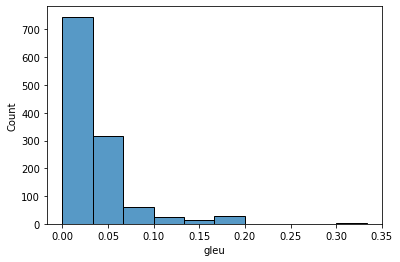

In [30]:
sns.histplot(data=df_metrics, x='gleu', bins=10)
# plt.show()
plt.savefig(os.path.join(output_dir, f'gleu_large_epoch_{epoch}.jpg'))

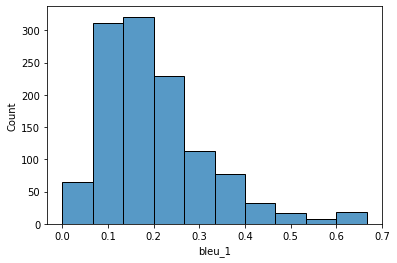

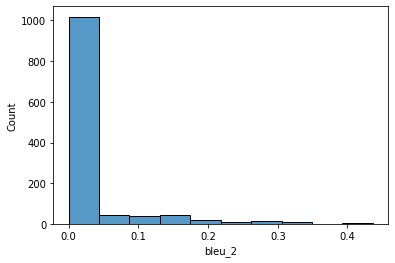

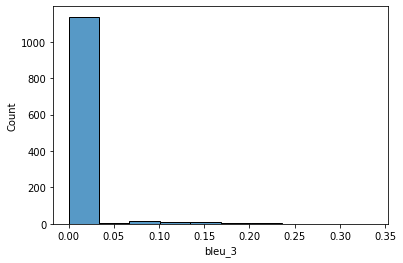

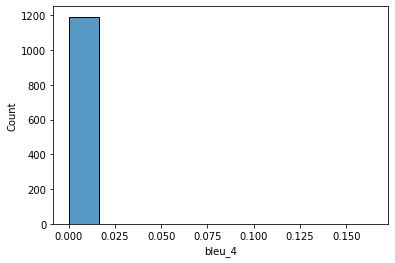

In [31]:
for i in range(1, bleu_max_order + 1):
    sns.histplot(data=df_metrics, x=f'bleu_{i}', bins=10)
    plt.show()
#     plt.savefig(os.path.join(output_dir, f'bleu_{i}_epoch_{epoch}.jpg'))

## Sanity check
Just to make sure that the model has trained as well as it could, a few sentences represented in the tensorflow example are tried. The model here performs similarly.

In [40]:
gt_from_example = [
    'and my neighboring homes heard about this idea',
    'this is a problem we have to solve',
    "so i 'll just share with you some stories very quickly of some magical things that have happened",
]

In [45]:
for i, (pt, en) in enumerate(dval):
    for gte in gt_from_example:
        if gte in en.numpy().decode('utf-8'):
            print(i)
            print('label\n', en.numpy().decode('utf-8'))
            print(f'prediction\n{preds[i]}\n')


106
label
 so i 'll just share with you some stories very quickly of some magical things that have happened .
prediction
i ' m going to talk a little bit about these two very interesting stories .

930
label
 and my neighboring homes heard about this idea .
prediction
my talk was about this .

1139
label
 this is a problem we have to solve .
prediction
this is a problem we need to do .

